<a href="https://colab.research.google.com/github/songhyunjung/movie_review/blob/main/movie_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필수 라이브러리 설치
# konlpy는 한국어 형태소 분석에 필요합니다.
# ------------------------------------------------
!pip install pandas numpy matplotlib seaborn scikit-learn konlpy
# ------------------------------------------------

# 드라이브 마운트 (데이터셋 저장 및 불러오기 위함)
# 데이터를 직접 Colab에 업로드하거나, Google Drive에 저장 후 경로를 지정할 수 있습니다.
# 드라이브에 저장하는 것을 권장합니다.
# ------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
# ------------------------------------------------

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 판다스 라이브러리 불러오기
import pandas as pd

# 훈련 데이터셋 파일 경로 (구글 드라이브에 저장했다고 가정)
train_path = '/content/drive/MyDrive/AI_movie_review/ratings_train.txt'
# 테스트 데이터셋 파일 경로
test_path = '/content/drive/MyDrive/AI_movie_review/ratings_test.txt'

# 훈련 데이터셋 로드 (tsv 파일이므로 sep='\t' 사용)
# ------------------------------------------------
train_df = pd.read_csv(train_path, sep='\t')
# 테스트 데이터셋 로드
test_df = pd.read_csv(test_path, sep='\t')
# ------------------------------------------------

# 데이터프레임의 상위 5개 행 출력하여 구조 확인
# ------------------------------------------------
print("훈련 데이터 상위 5행:")
print(train_df.head())
print("\n테스트 데이터 상위 5행:")
print(test_df.head())
# ------------------------------------------------

훈련 데이터 상위 5행:
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

테스트 데이터 상위 5행:
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


In [3]:
# 데이터의 정보 출력 (컬럼, 결측치 여부, 데이터 타입 등)
# ------------------------------------------------
print("\n훈련 데이터 정보:")
train_df.info()
print("\n테스트 데이터 정보:")
test_df.info()
# ------------------------------------------------

# 'document' 컬럼에 결측치(NaN)가 있는 행의 개수 확인
# ------------------------------------------------
print("\n훈련 데이터 'document' 컬럼 결측치 개수:", train_df['document'].isnull().sum())
print("테스트 데이터 'document' 컬럼 결측치 개수:", test_df['document'].isnull().sum())
# ------------------------------------------------

# 결측치(NaN)가 있는 모든 행 제거 (inplace=True로 원본 데이터프레임에 바로 적용)
# 'any'는 해당 행에 하나라도 결측치가 있으면 제거하라는 의미
# ------------------------------------------------
train_df.dropna(how = 'any', inplace=True)
test_df.dropna(how = 'any', inplace=True)
# ------------------------------------------------

# 'document' 컬럼 기준으로 중복된 행 제거
# keep='first'는 첫 번째 발견된 행을 남기고 나머지를 제거
# ------------------------------------------------
print("\n훈련 데이터 중복 제거 전 개수:", len(train_df))
train_df.drop_duplicates(subset=['document'], inplace=True)
print("훈련 데이터 중복 제거 후 개수:", len(train_df))
# ------------------------------------------------

# 감성 라벨(label) 컬럼의 값 분포 확인 (긍정/부정 비율)
# value_counts()는 각 고유 값의 개수를 세어 반환
# ------------------------------------------------
print("\n훈련 데이터 감성 라벨 분포:")
print(train_df['label'].value_counts())
# ------------------------------------------------

# 텍스트 데이터 전처리 함수 정의
# 정규표현식(re)을 사용하여 한글과 공백만 남기고 모두 제거
# ------------------------------------------------
import re
def clean_text(text):
    # 한글과 공백을 제외한 모든 문자를 제거
    text = re.sub(r'[^가-힣\s]', '', text)
    # 여러 개의 공백을 하나의 공백으로 축소
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# ------------------------------------------------

# 'document' 컬럼에 정의된 전처리 함수 적용
# apply() 함수는 DataFrame의 각 요소에 함수를 적용할 때 사용
# ------------------------------------------------
train_df['document'] = train_df['document'].apply(clean_text)
test_df['document'] = test_df['document'].apply(clean_text)
# ------------------------------------------------

# 전처리 후 빈 문자열이 된 리뷰는 제거 (이런 경우가 있을 수 있음)
# 텍스트 길이가 0인 경우를 찾아 제거
# ------------------------------------------------
train_df = train_df[train_df['document'].str.len() > 0]
test_df = test_df[test_df['document'].str.len() > 0]
# ------------------------------------------------

# 전처리 후 데이터 확인
# ------------------------------------------------
print("\n전처리 후 훈련 데이터 상위 5행:")
print(train_df.head())
print("\n전처리 후 훈련 데이터 개수:", len(train_df))
# ------------------------------------------------


훈련 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB

테스트 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB

훈련 데이터 'document' 컬럼 결측치 개수: 5
테스트 데이터 'document' 컬럼 결측치 개수: 3

훈련 데이터 중복 제거 전 개수: 149995
훈련 데이터 중복 제거 후 개수: 146182

훈련 데이터 감성 라벨 분포:
label
0    73342
1    72840
Name: count, dtype: int64

전처리 후 훈련 데이터 상위 5행:
         id                                           document

In [4]:
# TfidfVectorizer를 사용하기 위한 라이브러리 불러오기
# ------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
# ------------------------------------------------

# 훈련 데이터에서 'document' 컬럼을 텍스트 입력으로 사용
# 테스트 데이터에서 'document' 컬럼을 텍스트 입력으로 사용
# ------------------------------------------------
X_train = train_df['document']
y_train = train_df['label'] # 훈련 데이터의 라벨
X_test = test_df['document']
y_test = test_df['label']   # 테스트 데이터의 라벨
# ------------------------------------------------

# TfidfVectorizer 객체 초기화
# max_features: 사용할 단어(특징)의 최대 개수를 제한 (메모리 및 연산 효율성)
# ngram_range: 단어의 조합 (n-gram)을 고려 (예: (1, 2)는 단어 하나 또는 두 개의 조합 고려)
# ------------------------------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
# ------------------------------------------------

# 훈련 데이터에 TfidfVectorizer를 'fit'하고 'transform' 적용
# fit_transform은 훈련 데이터의 단어 사전을 구축하고 동시에 벡터화 진행
# ------------------------------------------------
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# ------------------------------------------------

# 테스트 데이터에 TfidfVectorizer를 'transform'만 적용 (훈련 데이터에서 학습된 단어 사전을 사용)
# ------------------------------------------------
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# ------------------------------------------------

# 변환된 벡터의 형태(shape) 출력하여 확인 (행: 문서 개수, 열: 특징(단어) 개수)
# ------------------------------------------------
print(f"훈련 데이터 TF-IDF 벡터 형태: {X_train_tfidf.shape}")
print(f"테스트 데이터 TF-IDF 벡터 형태: {X_test_tfidf.shape}")
# ------------------------------------------------

훈련 데이터 TF-IDF 벡터 형태: (145248, 20000)
테스트 데이터 TF-IDF 벡터 형태: (49430, 20000)


In [5]:
# 모델 학습을 위한 LogisticRegression 라이브러리 불러오기
# ------------------------------------------------
from sklearn.linear_model import LogisticRegression
# ------------------------------------------------

# 모델 평가를 위한 지표 라이브러리 불러오기
# accuracy_score: 정확도 계산
# classification_report: 정밀도, 재현율, F1-score 등 상세 평가 지표
# confusion_matrix: 혼동 행렬 생성
# ------------------------------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# ------------------------------------------------

# LogisticRegression 모델 객체 초기화
# solver='liblinear': 작은 데이터셋에 적합한 최적화 알고리즘
# random_state: 재현 가능한 결과를 위한 난수 시드 고정
# ------------------------------------------------
model = LogisticRegression(solver='liblinear', random_state=42)
# ------------------------------------------------

# 훈련 데이터를 사용하여 모델 학습
# ------------------------------------------------
print("모델 학습 시작...")
model.fit(X_train_tfidf, y_train)
print("모델 학습 완료!")
# ------------------------------------------------

# 학습된 모델을 사용하여 테스트 데이터 예측
# ------------------------------------------------
y_pred = model.predict(X_test_tfidf)
# ------------------------------------------------

# 모델의 정확도(Accuracy) 계산 및 출력
# ------------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"\n모델 정확도: {accuracy:.4f}")
# ------------------------------------------------

# 분류 보고서(Classification Report) 출력
# 정밀도, 재현율, F1-score 등을 포함한 상세 성능 지표
# ------------------------------------------------
print("\n분류 보고서:")
print(classification_report(y_test, y_pred))
# ------------------------------------------------

# 혼동 행렬(Confusion Matrix) 생성 및 출력
# 실제 라벨과 예측 라벨을 비교하여 모델의 분류 오류를 시각화
# TN(진짜 음성), FP(거짓 양성), FN(거짓 음성), TP(진짜 양성)
# ------------------------------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n혼동 행렬:")
print(conf_matrix)
# ------------------------------------------------

모델 학습 시작...
모델 학습 완료!

모델 정확도: 0.7910

분류 보고서:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     24562
           1       0.83      0.74      0.78     24868

    accuracy                           0.79     49430
   macro avg       0.79      0.79      0.79     49430
weighted avg       0.80      0.79      0.79     49430


혼동 행렬:
[[20811  3751]
 [ 6578 18290]]


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

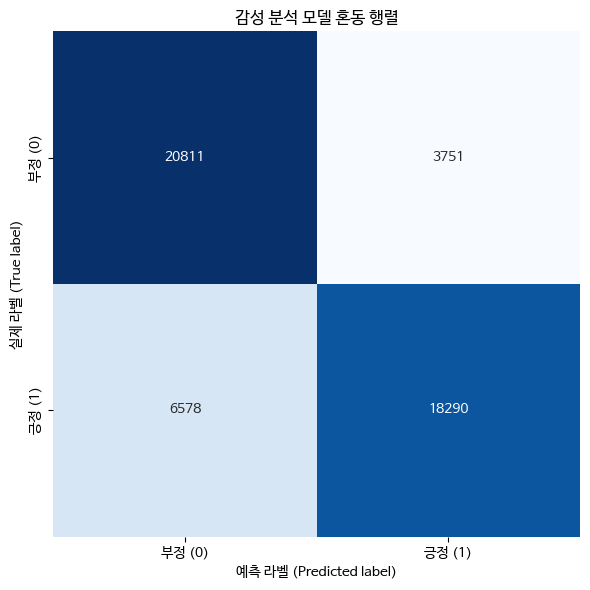

In [6]:
# 시각화를 위한 matplotlib, seaborn 라이브러리 불러오기
# ------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# ------------------------------------------------

# 한글 폰트 설정 (Colab에서 한글 깨짐 방지)
# Colab에서 매번 폰트 설치 필요
# ------------------------------------------------
plt.rc('font', family='Malgun Gothic') # 윈도우 환경
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# Colab에서 나눔 폰트 설치 (런타임 재시작 필요)
# ------------------------------------------------
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 '런타임' -> '런타임 다시 시작' 클릭
# 다시 시작한 후에는 폰트 설정 코드만 다시 실행하면 됩니다.
# ------------------------------------------------
# 폰트 다시 설정 (런타임 재시작 후)
# ------------------------------------------------
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
# ------------------------------------------------

# 혼동 행렬 시각화 함수 정의
# ------------------------------------------------
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    # 그림 크기 설정
    plt.figure(figsize=(6, 6))
    # Seaborn의 heatmap을 사용하여 혼동 행렬 그리기
    # annot=True: 셀 내부에 값 표시, fmt='d': 정수 형식으로 표시
    # cmap: 색상 맵, cbar=False: 컬러바 제거
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes)
    # x축 라벨 설정
    plt.xlabel('예측 라벨 (Predicted label)')
    # y축 라벨 설정
    plt.ylabel('실제 라벨 (True label)')
    # 그래프 제목 설정
    plt.title(title)
    # 그래프를 꽉 채우도록 설정
    plt.tight_layout()
    # 그래프 표시
    plt.show()
# ------------------------------------------------

# 클래스 이름 (0: 부정, 1: 긍정)
# ------------------------------------------------
class_names = ['부정 (0)', '긍정 (1)']
# ------------------------------------------------

# 혼동 행렬 시각화 함수 호출
# cm: 위에서 계산한 conf_matrix, class_names: 라벨 이름
# ------------------------------------------------
plot_confusion_matrix(conf_matrix, classes=class_names, title='감성 분석 모델 혼동 행렬')
# ------------------------------------------------

# 감성 라벨 분포 시각화 (데이터 전처리 파트에서 이미 출력했으므로 선택 사항)
# ------------------------------------------------
# plt.figure(figsize=(5, 4))
# sns.countplot(x='label', data=train_df)
# plt.title('훈련 데이터 감성 라벨 분포')
# plt.xlabel('감성 라벨 (0:부정, 1:긍정)')
# plt.ylabel('개수')
# plt.show()
# ------------------------------------------------

In [7]:
# 예측 결과와 실제 라벨을 포함하는 데이터프레임 생성
# ------------------------------------------------
result_df = pd.DataFrame({
    'document': X_test,        # 원본 테스트 리뷰 텍스트
    'true_label': y_test,      # 실제 라벨
    'pred_label': y_pred       # 모델의 예측 라벨
})
# 인덱스 재설정 (원래 인덱스가 유지되어 보기 불편할 수 있으므로)
# ------------------------------------------------
result_df.reset_index(drop=True, inplace=True)
# ------------------------------------------------

# 예측이 틀린 샘플 확인 (실제 라벨과 예측 라벨이 다른 경우)
# ------------------------------------------------
wrong_preds = result_df[result_df['true_label'] != result_df['pred_label']]
print("\n모델이 잘못 예측한 샘플 (상위 5개):")
print(wrong_preds.head())
# ------------------------------------------------

# 예측이 맞은 샘플 확인 (실제 라벨과 예측 라벨이 같은 경우)
# ------------------------------------------------
correct_preds = result_df[result_df['true_label'] == result_df['pred_label']]
print("\n모델이 올바르게 예측한 샘플 (상위 5개):")
print(correct_preds.head())
# ------------------------------------------------

# 특정 케이스 분석 (예: 실제는 긍정인데 부정으로 예측한 경우 - False Negative)
# ------------------------------------------------
false_negatives = result_df[(result_df['true_label'] == 1) & (result_df['pred_label'] == 0)]
print("\n실제는 긍정인데 부정으로 예측한 샘플 (False Negatives 상위 5개):")
print(false_negatives.head())
# ------------------------------------------------

# 특정 케이스 분석 (예: 실제는 부정인데 긍정으로 예측한 경우 - False Positive)
# ------------------------------------------------
false_positives = result_df[(result_df['true_label'] == 0) & (result_df['pred_label'] == 1)]
print("\n실제는 부정인데 긍정으로 예측한 샘플 (False Positives 상위 5개):")
print(false_positives.head())
# ------------------------------------------------


모델이 잘못 예측한 샘플 (상위 5개):
                           document  true_label  pred_label
0                                 굳           1           0
9                  괜찮네요오랜만포켓몬스터잼밌어요           1           0
12  눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다           1           0
14                   소위 문가라는 평점은 뭐냐           1           0
17                              나이스           1           0

모델이 올바르게 예측한 샘플 (상위 5개):
                                    document  true_label  pred_label
1           뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아           0           0
2                  지루하지는 않은데 완전 막장임 돈주고 보기에는           0           0
3  만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠           0           0
4                          음악이 주가 된 최고의 음악영화           1           1
5                                    진정한 쓰레기           0           0

실제는 긍정인데 부정으로 예측한 샘플 (False Negatives 상위 5개):
                           document  true_label  pred_label
0                                 굳           1           0
9        